Import libraries

In [1]:
from mortalityForecast import mortalityForecast as mf
from mortalityForecast import mortality_data_loader as data_loader
from mortalityForecast import utils

import matplotlib.pyplot as plt
import numpy as np

Set parameters

In [2]:
param = {
    'country' : data_loader.USA,
    'first_year_train' : 1933,
    'last_year_train' : 2000,
    'first_year_test' : 2001,
    'last_year_test' : 2019,
    'sex' : "Male", # or Female, Both
    'max_age' : 100,
    'nn_layers' : 2,
    'latent_dim' : 3
}

Load data

In [3]:
exposure_all, deaths_all = data_loader.load_data(param, train = True, test = True)
exposure_train, deaths_train = data_loader.load_data(param, train = True, test = False)
exposure_test, deaths_test = data_loader.load_data(param, train = False, test = True)

Create model

In [4]:
model = mf.Mortality(param)

Load already trained model

In [5]:
model_name = "%s_%d_%d_%s_%d_%d_%d" %(param['country'].name, param['first_year_train'], param['last_year_train'], param['sex'], param['max_age'], param['nn_layers'], param['latent_dim'])

file_name = "trainedModels/" + model_name

model = model.load(file_name = file_name, param = param, exposure = exposure_train, deaths = deaths_train )

Plot the smoothed factors against time

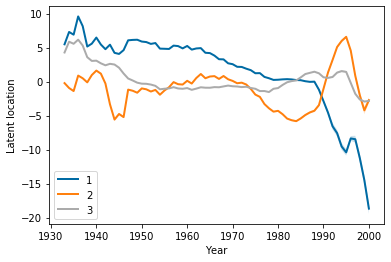

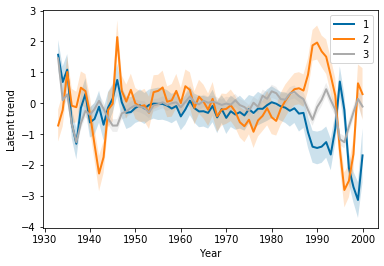

In [6]:
plt.style.use('tableau-colorblind10')

level_loc = model.level_loc
level_scale = model.level_scale

trend_loc = model.trend_loc
trend_scale = model.trend_scale

fig, ax = plt.subplots()
for i in range(level_loc.shape[0]):
    ax.plot(range(param['first_year_train'],param['last_year_train']+1), level_loc[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'],param['last_year_train']+1), 
                    level_loc[i] - level_scale[i], 
                    level_loc[i] + level_scale[i], 
                    alpha = 0.2)

plt.xlabel ('Year')
plt.ylabel ('Latent location')
plt.gca().legend(('1','2','3'))
fig.savefig("pics/latent_level.pdf", bbox_inches='tight', dpi=300)


fig, ax = plt.subplots()
for i in range(level_loc.shape[0]):
    ax.plot(range(param['first_year_train'],param['last_year_train']+1), trend_loc[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'],param['last_year_train']+1), 
                    trend_loc[i] - trend_scale[i], 
                    trend_loc[i] + trend_scale[i], 
                    alpha = 0.2)

plt.xlabel ('Year')
plt.ylabel ('Latent trend')
plt.gca().legend(('1','2','3'))

fig.savefig("pics/latent_trend_" + model_name + ".pdf", bbox_inches='tight', dpi=300)

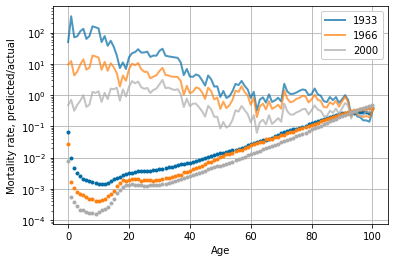

In [7]:
plt.style.use('tableau-colorblind10')

ax = plt.gca()

times = [0,
         int((param['last_year_train'] - param['first_year_train'])/2),
         param['last_year_train'] - param['first_year_train']]

mc = model.mortality_curve

for time in times:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(mc(time), color = color, linewidth = 2, alpha = 0.7, label = '%d' % (param['first_year_train'] + time))
    plt.plot(deaths_train[time,:]/exposure_train[time,:],'.', color = color, alpha = 1.0)

plt.yscale('log')
plt.xlabel ('Age')
plt.ylabel ('Mortality rate, predicted/actual')
plt.grid(True)
plt.legend(framealpha=1.0, frameon=True);

plt.savefig("pics/rateVsAge_" + model_name + ".pdf", bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Factor')

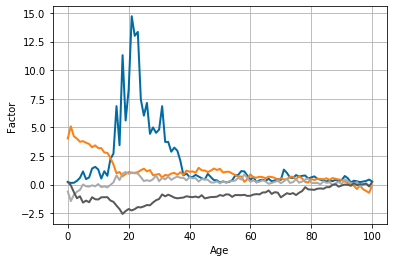

In [8]:
for factor in model.factor_loadings:
    plt.plot(factor, linewidth = 2)

plt.grid(True)
plt.xlabel ('Age')
plt.ylabel ('Factor')

In [ ]:
plt.style.use('tableau-colorblind10')

ages = [20, 40, 60, 80]

forecast_length = param['last_year_test'] - param['first_year_test'] +1
mc_samples = 10

color1 = next(ax._get_lines.prop_cycler)['color']
color2 = next(ax._get_lines.prop_cycler)['color']
color3 = next(ax._get_lines.prop_cycler)['color']

for age in ages:

    rate, scale = model.mortality(age, mc_samples = mc_samples)
    rate_f, scale_f = model.forecast_mortality_rate(age = age, forecast_length = forecast_length, mc_samples = 1000)
    
    fig, ax = plt.subplots()

    ax.plot(range(param['first_year_train'],param['last_year_train']+ 1), rate, linewidth = 2, color = color1)
    ax.plot(range(param['first_year_test'],param['last_year_test'] + 1), rate_f, linewidth = 2, color = color3)
    
    ax.fill_between(range(param['first_year_train'],param['last_year_train'] + 1), rate - scale, rate + scale, alpha=0.2, color = color1)
    ax.fill_between(range(param['first_year_test'],param['last_year_test'] + 1), rate_f - scale_f, rate_f + scale_f, alpha=0.2, color = color3)
    
    ax.plot(range(param['first_year_train'],param['last_year_test'] + 1), deaths_all[:,age]/exposure_all[:,age],'.', color = color1)

    plt.yscale('log')
    plt.xlabel ('Year')
    plt.ylabel ('Mortality rate ± 1 std, age %s' % age)
    fig.savefig("pics/rateVsTimeAge_" + model_name + str(age) + ".pdf", bbox_inches='tight', dpi=300)
    

In [ ]:
(level_f, scale_f) = model.forecast_factors( forecast_length = forecast_length )

level = np.concatenate((model.level_loc, level_f), axis = 1 )
scale = np.concatenate((model.level_scale, scale_f), axis = 1 )

fig, ax = plt.subplots()

for i in range(level.shape[0]):
    ax.plot(range(param['first_year_train'],param['last_year_test']+ 1), level[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'],param['last_year_test']+ 1), level[i] - scale[i], level[i] + scale[i], alpha=0.2)

plt.xlabel ('Year')
plt.ylabel ('Latent location ± 1 std')

fig.savefig("pics/latent_forecast_" + model_name + ".pdf", bbox_inches='tight', dpi=300)

In [ ]:
model.evaluate(exposure_test, deaths_test, mc_samples = 1000)